# Load packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install scanpy
!pip install matplotlib==3.1.3
!pip install -U tensorflow
!pip install celltypist

import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import scipy
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import celltypist
from celltypist import models

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.5 MB/s 
     |████████████████████████████████| 88 kB 6.3 MB/s 
     |████████████████████████████████| 11.2 MB 20.2 MB/s 
     |████████████████████████████████| 96 kB 3.0 MB/s 
     |████████████████████████████████| 959 kB 56.2 MB/s 
     |████████████████████████████████| 1.1 MB 50.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=4d645fc50e6e740b8a7bd6a9c98bf827c2eaa08dfeedc4c91670d29da13978c8
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=21188891d37de67db40ad07e11f4cd48f2cf308e5674224ce0c7c121790eecb5
  Stored in directory: /root/.cache/pip/wheels/7f/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 438 kB 43.3 MB/s 
     |████████████████████████████████| 5.9 MB 34.1 MB/s 
     |████████████████████████████████| 1.7 MB 71.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

In [2]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the pa

# Define VAE class

In [3]:
# Create weight constraint so that marker gene weights are non-negative
class BiasedNonNegative(tf.keras.constraints.Constraint):

  def __init__(self, weight_mask):
    self.marker_weight_mask = weight_mask
    self.NonMarker_weight_mask = 1 - weight_mask

# Multiply the weight matrix by weight mask
  def __call__(self, w):
    marker_sparse_w = w * self.marker_weight_mask                                                            # make marker weights sparse
    NonNeg_marker_sparse_w = marker_sparse_w * tf.cast(tf.math.greater_equal(marker_sparse_w, 0.), w.dtype)  # sparse * non-negativity constraint 
    NonMarker_sparse_w = w * self.NonMarker_weight_mask                                                      # make non-marker weights sparse
    return NonNeg_marker_sparse_w + NonMarker_sparse_w                                                       # add non-marker weights regardless of non-negativity

In [4]:
class SparseNonNegative(tf.keras.constraints.Constraint):

  def __init__(self, weight_mask):
    self.weight_mask = weight_mask

# Multiply the weight matrix by weight mask

  def __call__(self, w):
    w = w * self.weight_mask * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)    # sparse * non-negative 
    return w                   

In [5]:
class BiasedVAE(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties, weight_mask):
        super(BiasedVAE, self).__init__()  
        self.reg_penalties = reg_penalties
        self.encoder_weight_mask = tf.keras.backend.constant(weight_mask) 
        self.decoder_weight_mask = tf.keras.backend.constant(weight_mask.T)
        self.mean_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.encoder_weight_mask)),
        ])
        self.var_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.encoder_weight_mask)),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_regularizer=self.decoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.decoder_weight_mask))
        ])

    def reparameterization(self, mean, var):
        epsilon = tf.random.normal(shape = [mean.shape[1]])             
        z = mean + (var*epsilon)                       
        return z
        
    def call(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        z = self.reparameterization(mean, tf.exp(0.5 * log_var))
        p = tf.keras.activations.softmax(z)
        decoded = self.decoder(p)
        return decoded

    def embed(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        var = tf.exp(0.5 * log_var)
        return tf.keras.activations.softmax(mean), mean, var

    def encoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

In [6]:
class BiasedAE(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties, weight_mask):
        super(BiasedAE, self).__init__()  
        self.reg_penalties = reg_penalties
        self.encoder_weight_mask = weight_mask 
        self.decoder_weight_mask = weight_mask.T
        self.encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='softmax', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.encoder_weight_mask)),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_regularizer=self.decoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.decoder_weight_mask))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def embed(self, x):
      encoded = self.encoder(x)
      return encoded

    def encoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

In [7]:
class SparseVAE(Model):
    def __init__(self, num_cell_types, num_genes, weight_mask):
        super(SparseVAE, self).__init__()  
        self.encoder_weight_mask = tf.keras.backend.constant(weight_mask) 
        self.decoder_weight_mask = tf.keras.backend.constant(weight_mask.T)
        self.mean_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_constraint=SparseNonNegative(self.encoder_weight_mask)),
        ])
        self.var_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_constraint=SparseNonNegative(self.encoder_weight_mask)),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_constraint=SparseNonNegative(self.decoder_weight_mask))
        ])

    def reparameterization(self, mean, var):
        epsilon = tf.random.normal(shape = [mean.shape[1]])             
        z = mean + (var*epsilon)                       
        return z
        
    def call(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        z = self.reparameterization(mean, tf.exp(0.5 * log_var))
        p = tf.keras.activations.softmax(z)
        decoded = self.decoder(p)
        return decoded

    def embed(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        var = tf.exp(0.5 * log_var)
        return tf.keras.activations.softmax(mean), mean, var

In [8]:
class SparseAE(Model):
    def __init__(self, num_cell_types, num_genes, weight_mask):
        super(SparseAE, self).__init__()  
        self.encoder_weight_mask = weight_mask 
        self.decoder_weight_mask = weight_mask.T
        self.encoder = tf.keras.Sequential([
          layers.Dense(num_cell_types, 
                       activation='softmax', 
                       kernel_constraint=SparseNonNegative(self.encoder_weight_mask))
          ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, 
                       activation='linear', 
                       kernel_constraint = SparseNonNegative(self.decoder_weight_mask))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def embed(self, x):
      encoded = self.encoder(x)
      return encoded

# Define t-test computation function

In [9]:
def Compute_tTest(mean1,var1,mean2,var2,n):
  tScore = (mean1-mean2) / math.sqrt((var1+var2)/n)
  DegFreedom = ((((var1**2)+(var2**2))/n)**2) / ((((var1**2)+(var2**2))/(n**2))/(n-1))
  return scipy.stats.t.sf(abs(tScore), df=DegFreedom)

# Cell Type Assignment Function

In [10]:
from numpy.ma.core import true_divide
def CellTypeAssignment(dataset, Model = "Biased VAE", LearningRate = 1e-4, pValue = 2, MarkerBias = 1, NumEpochs = 50, NumTopGenes = 10):

    # Load Panglao DB marker gene list 
    print('Cell types with marker genes available in Panglao DB: \n')
    MarkerGeneList = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PanglaoDB_Markers.tsv",sep='\t')

    # Print expected cell type options 
    print(*list(pd.unique(MarkerGeneList['cell type'])), sep = "\n")
    print('\n')

    CellMarkers = pd.DataFrame(columns = MarkerGeneList.columns)
    PanglaoDB_list = CellMarkers['official gene symbol']
    AddCellType = "Y"
    while AddCellType == "Y":
        AddCellType = input("Add expected cell type: Y or N? ")
        while AddCellType not in ["Y","N"]:
            AddCellType = input("Add expected cell type: Y or N? ")
        if AddCellType == "Y":
            CellTypeOption = 'K'
            while CellTypeOption not in ["C", "P"]:
                CellTypeOption = input("To add custom expected cell type, type 'C'. To add expected cell type from Panglao DB, type 'P': ")
            if CellTypeOption == 'P':
                CellTypeInputRepeat = True
                while CellTypeInputRepeat == True:
                    TempCellType = input("Expected cell type: ")
                    if TempCellType not in list(pd.unique(CellMarkers['cell type'])):
                        CellTypeInputRepeat = False
                    else:
                        print("Expected cell type already inputted!")
                if TempCellType in list(pd.unique(MarkerGeneList['cell type'])): 
                    CellMarkers = CellMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == TempCellType))[0,:],:])
                else: 
                    print("The cell type inputted is not available in the Panglao DB database!")
                PanglaoDB_list = list(set(CellMarkers['official gene symbol']) & set(dataset.var_names))
                CellMarkers_list = []
                for gene in PanglaoDB_list:
                  if gene in list(CellMarkers['official gene symbol']):
                    CellMarkers_list.append({
                        'official gene symbol': gene,
                        'cell type': CellMarkers.loc[CellMarkers['official gene symbol'] == gene, 'cell type'].iloc[0]
                    })
                CellMarkers = pd.DataFrame(CellMarkers_list)
            else:
                CellTypeInputRepeat = True
                while CellTypeInputRepeat == True:
                    TempCellType = input("Expected cell type: ")
                    if TempCellType not in list(pd.unique(CellMarkers['cell type'])):
                        CellTypeInputRepeat = False
                    else:
                        print("Expected cell type already inputted!")
                CellTypeMarkerGenes = []
                KeepAdding = 'Y'
                while KeepAdding == 'Y':
                    AddMarker = input("Add marker gene: ")
                    if ((AddMarker in dataset.var_names) & (AddMarker not in CellMarkers['official gene symbol'])):
                        CellTypeMarkerGenes.append(AddMarker)
                    else:
                        print("Marker gene not available!")
                    KeepAdding = 'K'
                    while KeepAdding not in ['Y','N']:
                        KeepAdding = input("Add more markers: Y or N? ")
                CellType_df = pd.DataFrame({"official gene symbol":CellTypeMarkerGenes, 
                                            "cell type":[TempCellType]*len(CellTypeMarkerGenes)})
                PanglaoDB_list = list(set(PanglaoDB_list) & set(dataset.var_names))
                PanglaoDB_list = PanglaoDB_list + list(CellType_df['official gene symbol'])
                CellMarkers_list = []
                for gene in PanglaoDB_list:
                  if gene in list(CellMarkers['official gene symbol']):
                    CellMarkers_list.append({
                        'official gene symbol': gene,
                        'cell type': CellMarkers.loc[CellMarkers['official gene symbol'] == gene, 'cell type'].iloc[0]
                    })
                CellMarkers = pd.DataFrame(CellMarkers_list)
                CellMarkers = pd.concat([CellMarkers, CellType_df])   
    
    PanglaoDB_list = list(CellMarkers['official gene symbol'])

    print("\n")
    print(CellMarkers)
    print("\n")
    RenameCellTypes = 'Y'
    while RenameCellTypes == 'Y':
        print("Expected cell types: ")
        print(*list(pd.unique(CellMarkers['cell type'])), sep = ', ')
        print("\n")

        RenameCellTypes = 'K'
        while RenameCellTypes not in ['Y','N']:
            RenameCellTypes = input("Would you like to rename any expected cell types: Y or N? ")
            if RenameCellTypes == 'Y':
                ReplacementAvailable = 'N'
                while ReplacementAvailable == 'N':
                    ReplacedCellType = input("Expected cell type to replace: ")
                    if ReplacedCellType in list(pd.unique(CellMarkers['cell type'])):
                        ReplacementAvailable = 'Y'
                    else:
                        print('Expected cell type not available in current list!')
                Replacement = input("Replacement cell type: ")
                CellMarkers['cell type'] = CellMarkers['cell type'].replace(ReplacedCellType, Replacement)

    # Create a variable list for input genes / features 
    PanglaoDB_Input = []

    for i in range(dataset.shape[1]):
      if dataset.var_names[i] in PanglaoDB_list:
        PanglaoDB_Input.append(True)
      else: 
        PanglaoDB_Input.append(False)

    dataset.var['input_features'] = PanglaoDB_Input

    # Create anndata input for the model by filtering dataset
    dataset_input = dataset[:,dataset.var['input_features']]

    # Creating weight mask for marker genes
    marker_genes = dataset_input.var_names
    cell_types = pd.unique(CellMarkers['cell type'])

    marker_gene_cell_type_weight_mask = np.zeros((len(marker_genes), len(cell_types)))
    CellTypeMaskLabel = 0
    for i, gene in enumerate(marker_genes):
      for j, cell_type in enumerate(cell_types):
        is_marker_gene_for_cell_type = \
          CellMarkers[(CellMarkers['official gene symbol'] == gene) & 
                          (CellMarkers['cell type'] == cell_type)].shape[0] > 0
        if is_marker_gene_for_cell_type:   # Mask = 1
          marker_gene_cell_type_weight_mask[i, j] = 1
        else:                              # Mask = 0
          marker_gene_cell_type_weight_mask[i, j] = 0

    # Creating marker gene biased regularization mask 
    marker_gene_cell_type_reg_penalties = (1 - marker_gene_cell_type_weight_mask)*MarkerBias

    # Train the model 
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    NumCellTypes = len(CellMarkers['cell type'].unique())
    num_genes = dataset_input.shape[1]
    print(Model)
    if Model == "Biased VAE": 
        autoencoder = BiasedVAE(NumCellTypes, num_genes, 
                                marker_gene_cell_type_reg_penalties,
                                marker_gene_cell_type_weight_mask)
    elif Model == "Biased AE":
        autoencoder = BiasedAE(NumCellTypes, num_genes, 
                              marker_gene_cell_type_reg_penalties,
                              marker_gene_cell_type_weight_mask)
    elif Model == "Sparse VAE":
        autoencoder = SparseVAE(NumCellTypes, num_genes, 
                              marker_gene_cell_type_weight_mask)
    elif Model == "Sparse AE":
        autoencoder = SparseAE(NumCellTypes, num_genes,
                              marker_gene_cell_type_weight_mask)
    else:
        print('ERROR: select either Biased VAE, Biased AE, Sparse VAE or Sparse AE as your model.')
        return
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LearningRate), 
                        loss=losses.MeanSquaredError())
    
    print('\n')
    print('Training the autoencoder model...')
    print('\n')

    history = autoencoder.fit(dataset_input.X, dataset_input.X,
                              epochs=NumEpochs,
                              shuffle=True,
                              validation_data=(dataset_input.X, dataset_input.X))
    
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'])
    plt.title('Training loss over epochs')
    plt.ylabel('Mean squared error')
    plt.xlabel('Epochs')
    
    # Embed the model 
    if Model in ["Biased VAE","Sparse VAE"]: 
        latent_embedding, mean, var = autoencoder.embed(dataset_input.X)
    elif Model in ["Biased AE","Sparse AE"]:
        latent_embedding = autoencoder.embed(dataset_input.X)

    # assign cell type labels based on maximum probability in the latent layer output 
    cell_type_labels = []
    for item in latent_embedding:
        cell_type_labels.append(cell_types[np.where(item == max(item))[0][0]])

    # compute pValue of each assignment and assign 'unknown' labels according p-value threshold
    if Model in ["Biased VAE","Sparse VAE"]: 
        print('\n')
        print('Calculating p-value of cell type assignments...')
        print('\n')

        NumCells = dataset_input.shape[0]
        Cell_Assignment_PValues = []
        pVal_Threshold = pValue

        for cell in range(NumCells):
            MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
            pVal = []
            for LatentNode in range(NumCellTypes):
              if LatentNode != MaxIndex:
                pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
                                          mean[cell,LatentNode],var[cell,LatentNode],
                                          num_genes))
            Cell_Assignment_PValues.append(pVal[np.argmax(pVal)])
            if pVal[np.argmax(pVal)] > pVal_Threshold:
              print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
              cell_type_labels[cell] = 'Unknown'

        Cell_Assignment_PValues = np.array(Cell_Assignment_PValues).ravel()
        dataset.obs['pVal'] = Cell_Assignment_PValues
        dataset.obs['Predicted Cell Type'] = cell_type_labels
    else: 
        dataset.obs['Predicted Cell Type'] = cell_type_labels

    # Plot UMAP results 
    print('\n')
    print('Creating UMAP of cell type predictions...')
    print('\n')
    sc.tl.pca(dataset, use_highly_variable=False)
    # sc.tl.pca(dataset, svd_solver='arpack', use_highly_variable=False, n_comps = NumCellTypes)
    # dataset.obsm['X_pca'] = mean.numpy()
    sc.pp.neighbors(dataset)
    # sc.pp.neighbors(dataset, n_neighbors=10, n_pcs=NumCellTypes)
    sc.tl.umap(dataset)
    sc.pl.umap(dataset, color=['Predicted Cell Type'])

    # Plot gene weight activation 
    print('\n')
    print('Heatmap of Gene Activation...')
    print('\n')
    sns.heatmap(autoencoder.layers[0].get_weights()[0],
            xticklabels = cell_types,
            yticklabels = marker_genes)
    plt.show()

    # Print top 10 most activated genes for each cell type assignment 
    print('\n')
    print('Most Activated Genes for Each Cell...')
    print('\n')
    i = 0 
    for cell in cell_types:
        print(cell_types[i] + ': \n')
        j = 0
        for m in marker_genes[np.argsort(autoencoder.layers[0].get_weights()[0][:,i])[-NumTopGenes:]]:
            if marker_gene_cell_type_weight_mask[:,i][np.argsort(autoencoder.layers[0].get_weights()[0][:,i])[-NumTopGenes:]][j] == 0:
                print(m + ' (UNIDENTIFIED MARKER)')
            else:
                print(m)
            j += 1
        print('\n')
        i += 1 

    return dataset, autoencoder, CellMarkers

# Pancreas

In [37]:
# Load data matrix 
Pancreas_adata = sc.read_text('/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt', delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata) # scale data 

# Load ground truth cell type labels 
PancreasMetadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values

# Load cell barcodes 
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID

# Load gene list 
PancreasGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist

Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    obs: 'Cell Type'
    var: 'mean', 'std'

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

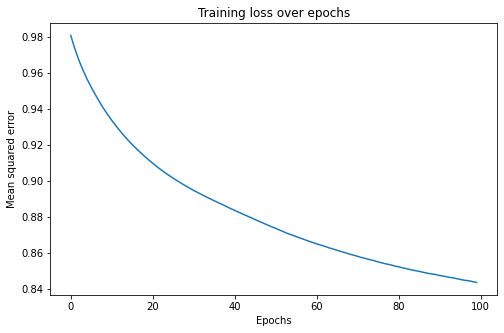

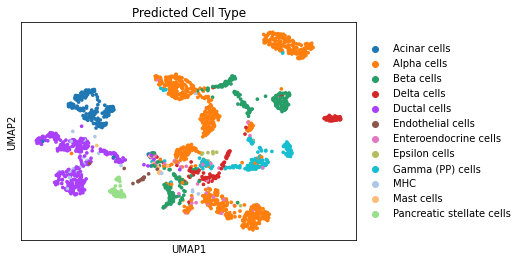



Heatmap of Gene Activation...




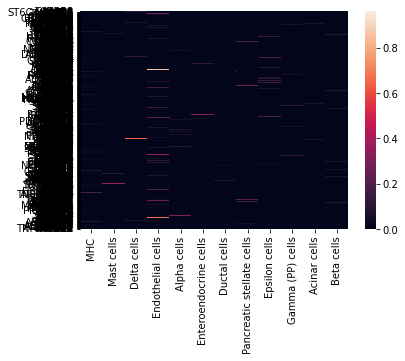



Most Activated Genes for Each Cell...


MHC: 

KLHL6
SIGLEC6
VSIG4
CTSS
CD33
CXCL16
LGALS3
CD74
CD24
CXCR3


Mast cells: 

CMA1
CFP
DCLK3
TPSAB1
RGS13
ST6GALNAC3
CXCR2
CCR3
TPSB2
EDNRA


Delta cells: 

FRZB
GHSR
BAIAP3
GPC5-AS1
GABRB3
LEPR
BCHE
FFAR4
SST
RBP4


Endothelial cells: 

ERG
FLT1
TMEM100
SELE
ROBO4
CDH5
SOX18
CCL19
CD93
EMCN


Alpha cells: 

GLP1R
RGS4
PCSK1
PAX6
ALDH1A1
TM4SF4
CHGA
TTR
SCGN
PCSK2


Enteroendocrine cells: 

VEGFA
FABP5
FFAR1
RIMBP2
NUCB2
SSTR2
VWA5B2
CPE
ENPP2
CHGB


Ductal cells: 

KRT7
LGALS4
PERP
LAMB3
CLDN1
PIGR
TACSTD2
CLDN4
CTSH
ANXA4


Pancreatic stellate cells: 

COL6A3
NDUFA4L2
INHBA
COL1A2
TIMP3
TIMP1
THY1
COL3A1
SPON2
SFRP2


Epsilon cells: 

VSTM2L
PTGER4
AFF3
BHMT
COX6A2
OPRK1
HMGCS2
GHRL
APOH
SPTSSB


Gamma (PP) cells: 

PTGFR
LMO3
MEIS1
PXK
SEMA3E
SLITRK6
SERTM1
THSD7A
ABCC9
PPY


Acinar cells: 

CPA1
PDZK1IP1
PRSS1
CFB
REG1A
AKR1C3
GDF15
MUC1
CLPS
SERPINA3


Beta cells: 

SYT13
NPTX2
EFNA5
ADCYAP1
BMP5
PFKFB2
ISL1
CASR
ERO1LB
INS




In [87]:
Pancreas_adata, Pancreas_VAE, PancreasMarkers = CellTypeAssignment(Pancreas_adata, 
                                                                   Model = "Sparse AE",
                                                                   LearningRate = 1e-3,
                                                                   MarkerBias = 1, 
                                                                   pValue = 2, 
                                                                   NumEpochs = 100)

In [88]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/'
Pancreas_adata.obs.to_csv(dir + 'sparseAE_pancreas_predictions.csv')
PancreasMarkers.to_csv(dir + 'sparseAE_pancreas_markers.csv')

# GBM 

In [12]:
# Read and process GBM data 
GBM_adata = sc.read_text("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

# Regress out cell cycle scores
GBMCellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

# Load ground truth cell type labels 
GBM_Metadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

# Load gene list 
GBMGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

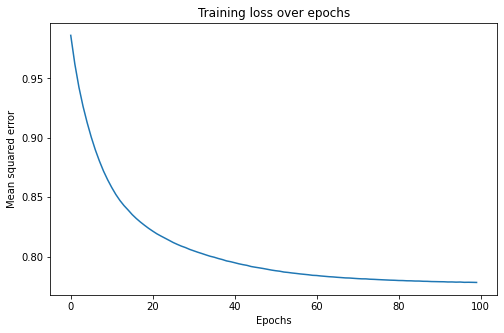

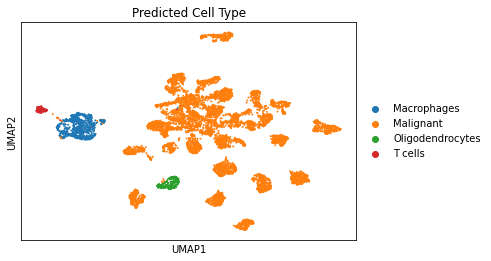



Heatmap of Gene Activation...




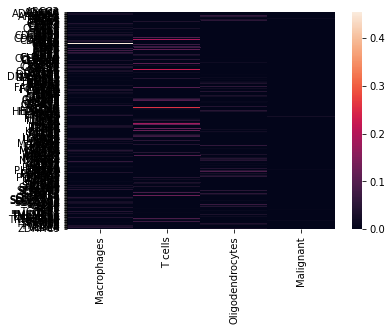



Most Activated Genes for Each Cell...


Macrophages: 

VSIG4
SLC11A1
MS4A4A
IL1B
CD68
CPM
NR4A3
CD83
CD74
CD3E


T cells: 

IL7R
CD8B
JUNB
SKAP1
SH2D1A
IL32
CD247
CXCR4
GZMA
CD4


Oligodendrocytes: 

SGK2
HDAC11
BCAS1
FA2H
PLEKHH1
MBP
ANLN
OMG
SOX10
PLP1


Malignant: 

ENPP6 (UNIDENTIFIED MARKER)
CD33
RB1
TNFRSF1A
CD44
TERT
PIK3CA
TP53
ATRX
IDH1




In [52]:
GBM_adata, GBM_VAE, GBM_Markers = CellTypeAssignment(GBM_adata,
                                                     Model = "Sparse VAE", 
                                                     LearningRate = 1e-3, 
                                                     MarkerBias = 1,
                                                     pValue = 2, 
                                                     NumEpochs = 100)

In [53]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/'
GBM_adata.obs.to_csv(dir + 'sparseAE_GBM_predictions.csv')
GBM_Markers.to_csv(dir + 'sparseAE_GBM_markers.csv')

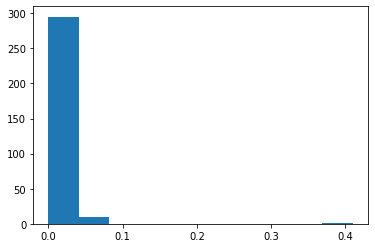

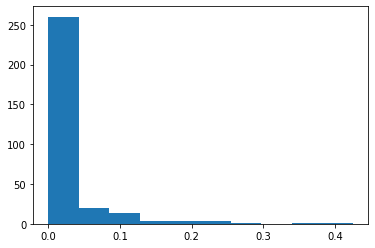

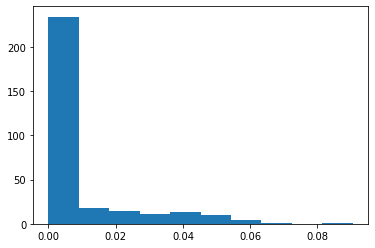

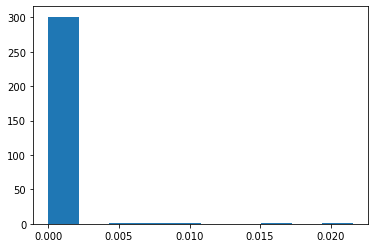

In [17]:
# Oligodendrocytes
plt.hist(GBM_VAE.layers[0].get_weights()[0][:,0])
plt.show()

# Macrophages
plt.hist(GBM_VAE.layers[0].get_weights()[0][:,1])
plt.show()

# T cells 
plt.hist(GBM_VAE.layers[0].get_weights()[0][:,2])
plt.show()

# Malignant 
plt.hist(GBM_VAE.layers[0].get_weights()[0][:,3])
plt.show()

# PBMC

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the pa

In [ ]:
PBMC_adata_original = sc.read_text("/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/matrix.txt", delimiter = '\t', first_column_names=None)
PBMC_adata_original = PBMC_adata_original.T

# Load gene list 
PBMC_Genes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/features.txt")
PBMC_Genelist = []
for item in PBMC_Genes.values:
  PBMC_Genelist.append(item[0])
PBMC_adata_original.var_names = PBMC_Genelist

PBMC_Truth = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/Ground_Truth_PBMC3k.csv")
PBMC_adata_original.obs['Cell Type'] = PBMC_Truth['orig_id'].values

PBMC_adata_original

AnnData object with n_obs × n_vars = 2467 × 13714
    obs: 'Cell Type'

In [ ]:
# Data processing for CellTypist
PBMC_adata = PBMC_adata_original
UnitNormalized_X = (PBMC_adata.X - np.amin(PBMC_adata.X)) / (np.amax(PBMC_adata.X) - np.amin(PBMC_adata.X))
PBMC_adata.X = UnitNormalized_X 

sc.pp.normalize_total(PBMC_adata, target_sum=10000)
sc.pp.log1p(PBMC_adata)
PBMC_adata.X = scipy.sparse.csr_matrix(PBMC_adata.X)
PBMC_adata.X.expm1().sum(axis = 1)

PBMC_adata.raw = PBMC_adata
PBMC_adata

AnnData object with n_obs × n_vars = 2467 × 13714
    obs: 'Cell Type'
    uns: 'log1p'

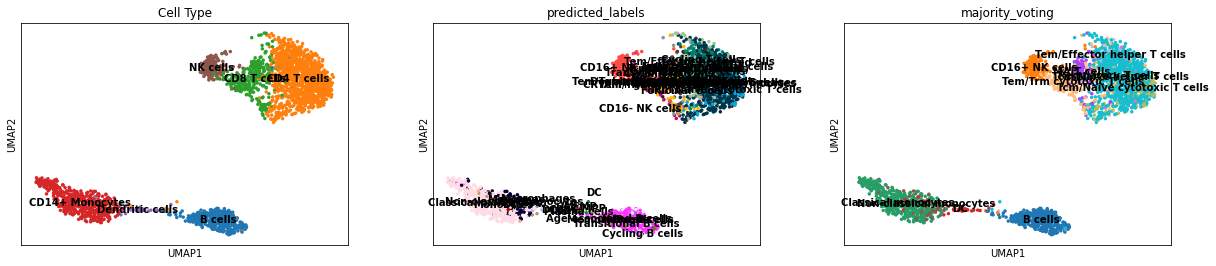

In [ ]:
# Run CellTypist
models.download_models(force_update = True)
models.models_path
model = models.Model.load(model = 'Immune_All_Low.pkl')

predictions = celltypist.annotate(PBMC_adata, model = 'Immune_All_Low.pkl', majority_voting = True)
adata = predictions.to_adata()

sc.pp.pca(adata, use_highly_variable=False)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['Cell Type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/'
adata.obs.to_csv(dir + 'CellTypist_PBMC_predictions.csv')

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

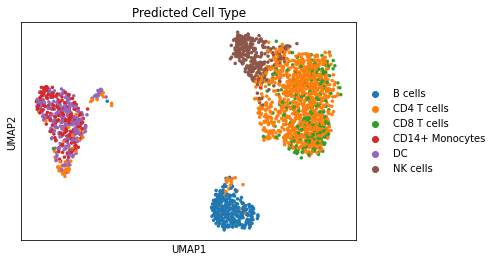



Heatmap of Gene Activation...




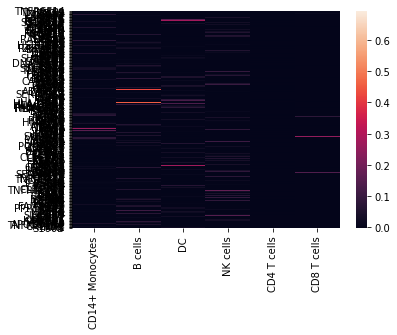



Most Activated Genes for Each Cell...


CD14+ Monocytes: 

CSF3R
CFP
SPI1
CD68
MS4A6A
RGS2
PYCARD
PSAP
TYMP
FCN1


B cells: 

HVCN1
SPIB
BANK1
VPREB3
HLA-DQA1
CD79A
CD79B
MS4A1
CD74
HLA-DRA


DC: 

HLA-DPA1
LST1
HLA-DQB1
HLA-DPB1
AIF1
HLA-DRB1
CTSS
FTL
LYZ
S100A9


NK cells: 

PRF1
GZMB
CST7
SPON2
FGFBP2
GZMA
CTSW
NKG7
CCL5
CD27


CD4 T cells: 

CAMK2D (UNIDENTIFIED MARKER)
TBX21 (UNIDENTIFIED MARKER)
SERPINB9 (UNIDENTIFIED MARKER)
CADM1 (UNIDENTIFIED MARKER)
DOK3 (UNIDENTIFIED MARKER)
LTB (UNIDENTIFIED MARKER)
MGMT (UNIDENTIFIED MARKER)
IL32 (UNIDENTIFIED MARKER)
SEC61A1 (UNIDENTIFIED MARKER)
IL10


CD8 T cells: 

HMBOX1 (UNIDENTIFIED MARKER)
CD69 (UNIDENTIFIED MARKER)
EDEM2 (UNIDENTIFIED MARKER)
ZNF683
PDCD1
PAGE5
PRKCH
NUCB2
LEF1
CD27




In [ ]:
# Run VAE model
PBMC_adata = PBMC_adata_original 
sc.pp.scale(PBMC_adata)

PBMC_adata, PBMC_VAE, PBMC_Markers = CellTypeAssignment(PBMC_adata, LearningRate = 1e-3, pValue = 2, NumEpochs = 200)

Cell type labels: 
- NK cells
- B cells
- Dendritic cells
- Monocytes
- Regulatory T cells (CT)
- Tem/Trm cytotoxic T cells (CT)
- Tcm/Naive cytotoxic T cells (CT)
- MAIT cells (CT)
- Tem/Effector helper T cells (CT) 
- Tcm/Naive helper T cells (CT) 

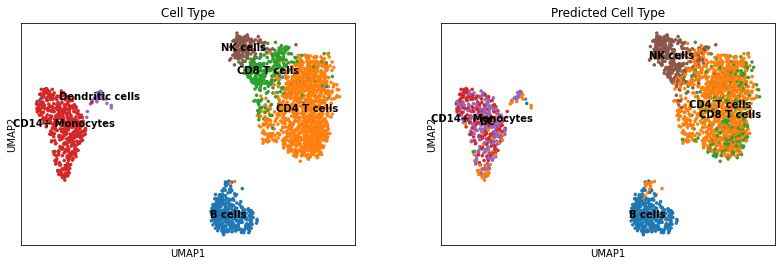

In [ ]:
sc.pl.umap(PBMC_adata, 
           color=['Cell Type','Predicted Cell Type'],
           legend_loc = 'on data')

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/'
PBMC_adata.obs.to_csv(dir + 'biasedVAE_PBMC_predictions.csv')
PBMC_Markers.to_csv(dir + 'biasedVAE_PBMC_markers.csv')

# CellTypist Immune Cells

In [ ]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', 
                     backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

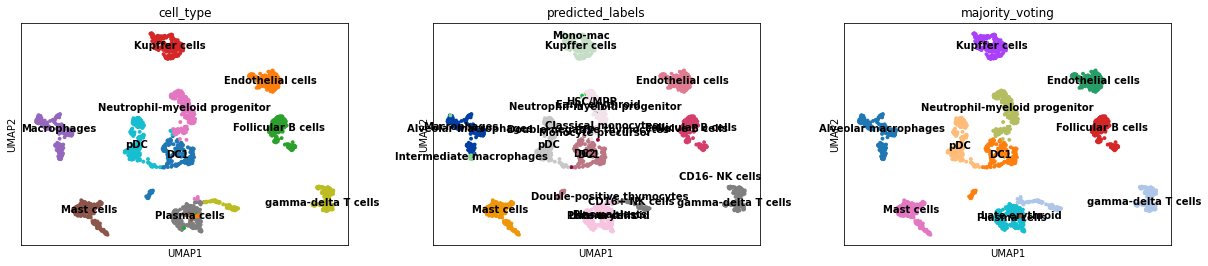

In [ ]:
models.download_models(force_update = True)
models.models_path
model = models.Model.load(model = 'Immune_All_Low.pkl')

predictions = celltypist.annotate(adata_2000, model = 'Immune_All_Low.pkl', majority_voting = True)
adata_2000 = predictions.to_adata()

sc.pp.pca(adata_2000, use_highly_variable=False)
sc.pp.neighbors(adata_2000)
sc.tl.umap(adata_2000)
sc.pl.umap(adata_2000, color = ['cell_type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/CellTypist Data/'
adata_2000.obs.to_csv(dir + 'CellTypist_CTdata_predictions.csv')

In [ ]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', 
                     backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')
adata_2000.X = adata_2000.X.toarray()

# Regress out cell cycle scores
CT_CellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/CellTypist Data/CellCycleScore.csv",
                                   delimiter=',')
adata_2000.obs['score_S'] = CT_CellCycleScores['score_S'].values
adata_2000.obs['score_G2M'] = CT_CellCycleScores['score_G2M'].values
sc.pp.regress_out(adata_2000, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(adata_2000)

adata_2000

  0%|          | 0.00/34.1M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2000 × 18950
    obs: 'cell_type', 'score_S', 'score_G2M'
    var: 'mean', 'std'

In [ ]:
adata_2000, CT_VAE, CT_Markers = CellTypeAssignment(adata_2000, LearningRate = 1e-3, pValue = 2, NumEpochs = 100)

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

ImportError: ignored

<Figure size 432x288 with 1 Axes>



Heatmap of Gene Activation...




ImportError: ignored

<Figure size 432x288 with 2 Axes>



Most Activated Genes for Each Cell...


Endothelial cells: 

MGLL
SRGN
SLCO1C1
SPARC
PTPRB
BMP2
GJA5
VEGFC
VWA1
NPR1


Follicular B cells: 

CXCR4 (UNIDENTIFIED MARKER)
CD83
CXCR5
CD22
RPL41
MT-RNR2
TNFRSF13B
GAS5
VPREB3
IGHA1


Gamma delta T cells: 

HOPX
CST7
GNLY
TRGC2
NKG7
KLRD1
CTSW
TRDC
GZMA
IFITM1


Mast cells: 

MITF
MEIS2
CPA3
HPGDS
KIT
VWA5A
MLPH
HS3ST1
ENPP3
SLC45A3


pDC: 

SGCE (UNIDENTIFIED MARKER)
RND1 (UNIDENTIFIED MARKER)
LOX (UNIDENTIFIED MARKER)
STAB2 (UNIDENTIFIED MARKER)
OGDHL
FOXH1
DRAIC
LILRA4
IL3RA
PLD4


Plasma cells: 

BIRC5 (UNIDENTIFIED MARKER)
GNAI1 (UNIDENTIFIED MARKER)
LOX (UNIDENTIFIED MARKER)
STAB2 (UNIDENTIFIED MARKER)
ARMCX3 (UNIDENTIFIED MARKER)
IGHA2
XBP1
IGKC
MZB1
JCHAIN


Macrophages: 

TREM2
FTH1
APOE
APOC1
C1QA
C1QB
FTL
SELENOP
CD68
CD5L


Neutrophil-myeloid progenitor: 

EGR2 (UNIDENTIFIED MARKER)
LSAMP (UNIDENTIFIED MARKER)
CENPA (UNIDENTIFIED MARKER)
MCEMP1 (UNIDENTIFIED MARKER)
PROCR (UNIDENTIFIED MARKER)
LOX (UNIDENTIFIED MARKER)
STAB2 (U

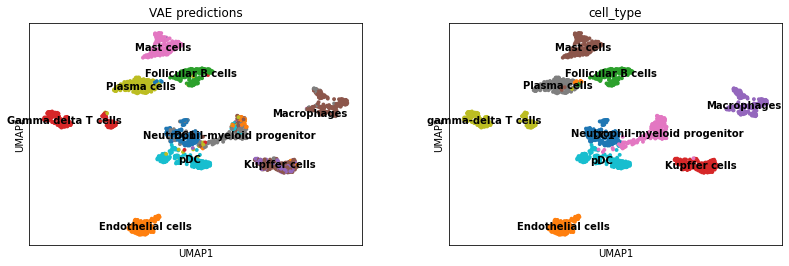

In [ ]:
adata_2000.obs['VAE predictions'] = adata_2000.obs['Predicted Cell Type'].values
sc.pl.umap(adata_2000, color = ['VAE predictions','cell_type'], legend_loc = 'on data')

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/CellTypist Data/'
adata_2000.obs.to_csv(dir + 'biasedVAE_CTdata_predictions.csv')
CT_Markers.to_csv(dir + 'biasedVAE_CTdata_markers.csv')

# Mouse Kidney

In [10]:
# Load normalized cell count matrix 
MouseKidney_adata = sc.read_csv('/content/drive/MyDrive/ML for genomics project group /Data/scCATCH Data /mouse_kidney_norm_exp.csv').T

# Load normalized cell count matrix with gene mean and std deviation 
MouseKidney_adata_std_mean = sc.read_csv('/content/drive/MyDrive/ML for genomics project group /Data/scCATCH Data /MouseKidney Norm Exp.csv').T

# Load ground truth cell type labels 
MouseKidney_GroundTruth = pd.read_csv('/content/drive/MyDrive/ML for genomics project group /Data/scCATCH Data /Ground_Truth_Label_mouse_kidney_203_cells.csv')

# Adding cell type column in adata.obs dataframe 
MouseKidney_adata.obs['Cell Type'] = MouseKidney_GroundTruth['mouse_kidney_203_cluster'].values

sc.pp.scale(MouseKidney_adata)
MouseKidney_adata

AnnData object with n_obs × n_vars = 203 × 1564
    obs: 'Cell Type'
    var: 'mean', 'std'

In [45]:
MouseKidney_adata.var_names

Index(['Cav2', 'Slc22a18', 'Sdhd', 'Ccnd2', 'Slfn4', 'Scnn1g', 'Itgb2',
       'Ckmt1', 'Clec10a', 'Arvcf',
       ...
       'Tlnrd1', 'Atp5md', 'Ifi213', 'Selenos', 'Selenom', 'Nat8f6', 'Cstdc4',
       'Carmn', 'Gm31243', 'Gm30211'],
      dtype='object', length=1564)

In [44]:
# Does not work because the gene variables set in the AnnData is too small --> does not encompass the requisite marker genes 
MouseKidney_adata, MouseKidney_VAE, MouseKidney_Markers = CellTypeAssignment(MouseKidney_adata, 
                                                                             Model = "Biased VAE",
                                                                             LearningRate = 1e-3, 
                                                                             pValue = 2, 
                                                                             NumEpochs = 100,
                                                                             NumTopGenes = 10)

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

KeyboardInterrupt: ignored